# **Product Recommendation System**

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


Loadind Dataset

In [ ]:
import pandas as pd
path=r'BigBasket Products.csv'
df=pd.read_csv(path)

In [ ]:
df.head(5)

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."
3,4,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,Nakoda,149.0,176.0,"Laundry, Storage Baskets",3.7,Multipurpose container with an attractive desi...
4,5,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,Nivea,162.0,162.0,Bathing Bars & Soaps,4.4,Nivea Creme Soft Soap gives your skin the best...


Checking for duplicate and null values

In [ ]:
print(f"Duplicate Rows: {df.duplicated().sum()}")

Duplicate Rows: 0


In [ ]:
print(df.isnull().sum())
df = df.dropna().reset_index(drop=True)


index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64


In [ ]:
df.shape

(18840, 10)

Exploratory Data Analysis

Count of Items in Each Category

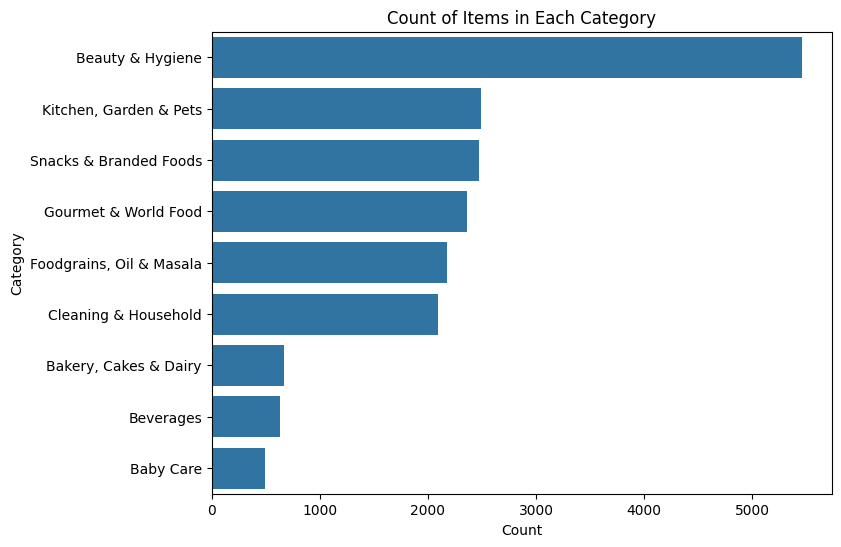

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(y=df["category"], order=df["category"].value_counts().index)
plt.title("Count of Items in Each Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.show()


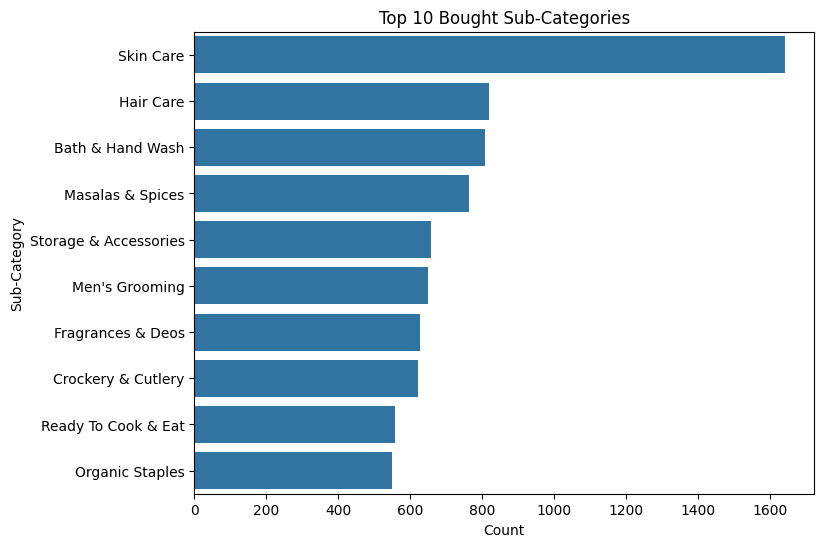

In [ ]:
#Top 10 Bought Sub-Categories
plt.figure(figsize=(8, 6))
top_subcategories = df["sub_category"].value_counts().head(10)
sns.barplot(x=top_subcategories.values, y=top_subcategories.index)
plt.title("Top 10 Bought Sub-Categories")
plt.xlabel("Count")
plt.ylabel("Sub-Category")
plt.show()


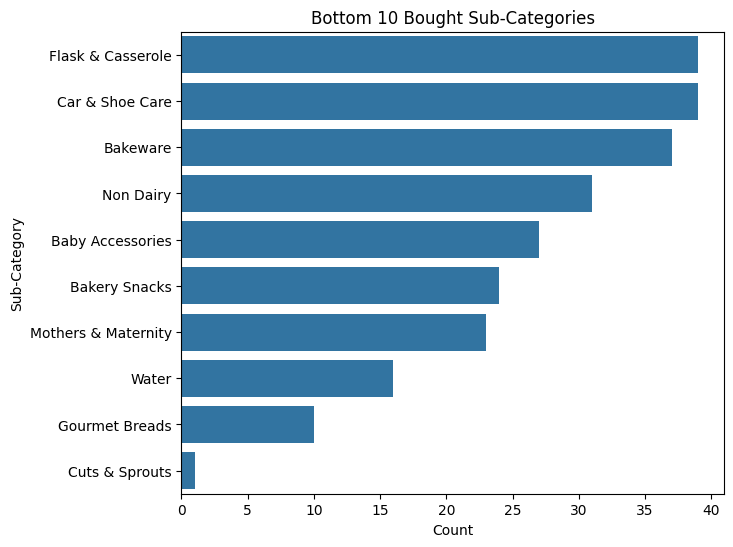

In [ ]:
#Bottom 10 Bought Sub-Categories
plt.figure(figsize=(7, 6))
bottom_subcategories = df["sub_category"].value_counts().tail(10)
sns.barplot(x=bottom_subcategories.values, y=bottom_subcategories.index)
plt.title("Bottom 10 Bought Sub-Categories")
plt.xlabel("Count")
plt.ylabel("Sub-Category")
plt.show()



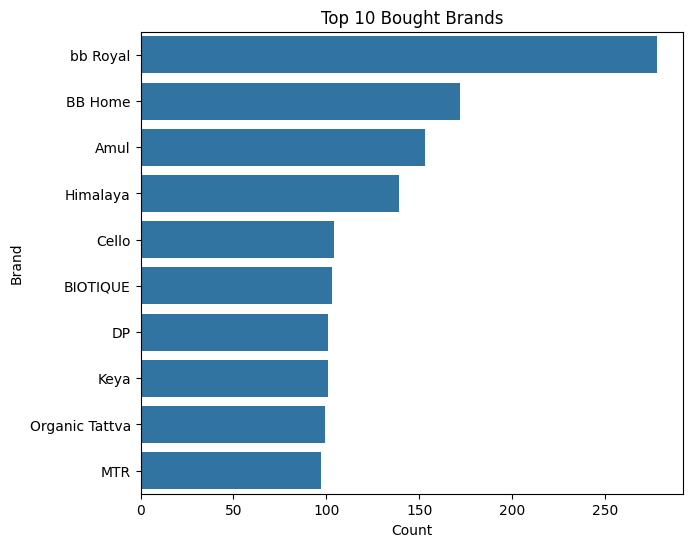

In [ ]:
#Top 10 Bought Brands
plt.figure(figsize=(7, 6))
top_brands = df["brand"].value_counts().head(10)
sns.barplot(x=top_brands.values, y=top_brands.index)
plt.title("Top 10 Bought Brands")
plt.xlabel("Count")
plt.ylabel("Brand")
plt.show()


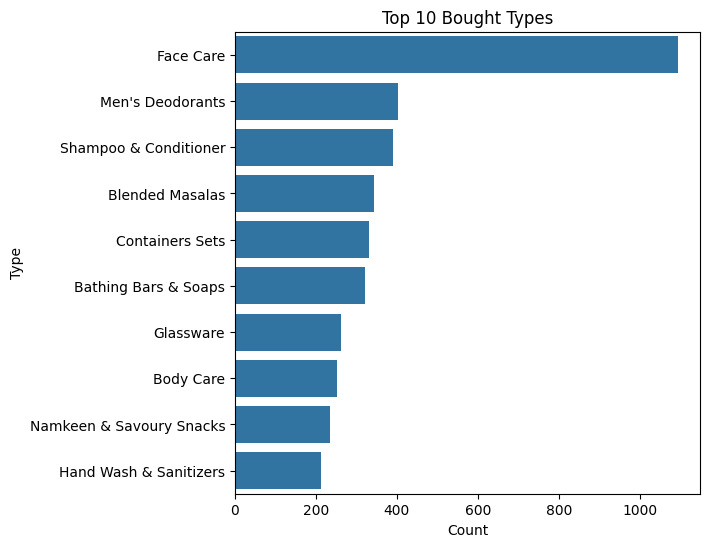

In [ ]:
#Top 10 Bought Types
plt.figure(figsize=(6, 6))
top_types = df["type"].value_counts().head(10)
sns.barplot(x=top_types.values, y=top_types.index)
plt.title("Top 10 Bought Types")
plt.xlabel("Count")
plt.ylabel("Type")
plt.show()


Data Cleaning

In [ ]:

def clean_text(text):
    return re.sub(r'[^a-zA-Z0-9]', ', ', str(text)).lower().split(', ')

df["category"] = df["category"].apply(clean_text)
df["sub_category"] = df["sub_category"].apply(clean_text)
df["type"] = df["type"].apply(clean_text)
df["brand"] = df["brand"].apply(clean_text)

# Convert list back to string for later processing
df["category"] = df["category"].apply(lambda x: ' '.join(x))
df["sub_category"] = df["sub_category"].apply(lambda x: ' '.join(x))
df["type"] = df["type"].apply(lambda x: ' '.join(x))
df["brand"] = df["brand"].apply(lambda x: ' '.join(x))


In [ ]:

def normalize_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', '', text)
    return text

df["normalized_product"] = df["product"].apply(normalize_text)
df["normalized_description"] = df["description"].apply(normalize_text)


In [ ]:
df["combined_features"] = df["category"] + " " + df["sub_category"] + " " + df["type"] + " " + df["brand"] + " " + df["description"]

In [ ]:
vectorizer = TfidfVectorizer(stop_words="english")
feature_matrix = vectorizer.fit_transform(df["combined_features"])

In [ ]:
similarity_matrix = cosine_similarity(feature_matrix)
print(similarity_matrix)

NameError: name 'cosine_similarity' is not defined

Recommendation System

In [ ]:
def recommend_products(search_term, min_price=None, max_price=None, min_rating=None):
    search_term = normalize_text(search_term)  # Normalize user input

    # Find matching product based on normalized name or description
    matches = df[
        (df["normalized_product"].str.contains(search_term, na=False)) |
        (df["normalized_description"].str.contains(search_term, na=False))
    ]

    if matches.empty:
        return "No products found for the given search term."

    product_index = matches.index[0]  # Taking the first match

    # Get similarity scores and sort products
    scores = list(enumerate(similarity_matrix[product_index]))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

    # Collect recommendations
    recommendations = []
    for index, score in sorted_scores:
        product = df.iloc[index]

        # Apply filters **ONLY IF user provides them**
        if min_price is not None and product["sale_price"] < min_price:
            continue
        if max_price is not None and product["sale_price"] > max_price:
            continue
        if min_rating is not None and product["rating"] < min_rating:
            continue

        recommendations.append((product["product"], product["sale_price"], product["rating"], score))

        if len(recommendations) >= 10:
            break

    # If no filters were applied, return top 10 based on similarity only
    if min_price is None and max_price is None and min_rating is None:
        recommendations = [(df.iloc[i]["product"], df.iloc[i]["sale_price"], df.iloc[i]["rating"], s)
                           for i, s in sorted_scores[:10]]

    return pd.DataFrame(recommendations, columns=["Product", "Price", "Rating", "Similarity Score"])


In [ ]:
print(recommend_products(search_term="Nivea cream", min_price=200, max_price=500, min_rating=4))

                                             Product   Price  Rating  \
0  Soft Light Moisturiser For Face, Hand & Body -...  259.00     4.4   
1  Musk Talcum Powder For Men & Women - Fragrance...  224.10     4.3   
2       Soft Light Moisturising Cream - Chilled Mint  259.20     4.3   
3  Whitening Smooth Skin Women Deodorant For 48h ...  292.59     4.1   
4  Musk Talcum Powder For Men & Women - Fragrance...  224.10     4.3   
5  Body Lotion For Very Dry Skin - Cocoa Nourish,...  261.25     4.2   
6  Aloe Protection Body Lotion - SPF 15, For Men ...  276.25     4.2   
7  Pure Talcum Powder For Men & Women - For Gentl...  224.10     4.4   
8  Body Lotion, Whitening Cool Sensation, SPF 15 ...  370.00     4.1   
9                  Protect & Care After Shave Lotion  219.84     4.2   

   Similarity Score  
0          0.394307  
1          0.392295  
2          0.389719  
3          0.383701  
4          0.370028  
5          0.368671  
6          0.368469  
7          0.353288  
8        

In [ ]:
print(recommend_products(search_term="hair oil", min_price=100, max_price=150, min_rating=4))

                                          Product  Price  Rating  \
0                 Naturals Spanish Olive Hair Oil  150.0     4.7   
1                          Anti-Hair Fall Shampoo  123.5     4.2   
2                    Hair fall Rescue Conditioner  133.0     4.2   
3                                Oil - Kesh Kanti  130.0     4.4   
4           Non-Sticky Hair Oil - Walnut & Almond  140.0     4.0   
5                      Serum for Dry & Rough Hair  120.0     4.3   
6                       Hair Oil - Ayurvedic Care  120.0     4.3   
7   Hair Fruits Long & Silky Conditioning Shampoo  128.0     4.0   
8                              Nourishing Shampoo  130.0     4.8   
9  Hair Fruits Shining Black Conditioning Shampoo  128.0     4.2   

   Similarity Score  
0          0.449085  
1          0.415387  
2          0.399119  
3          0.387494  
4          0.386571  
5          0.376507  
6          0.366080  
7          0.363699  
8          0.351461  
9          0.350799  


In [ ]:
print(recommend_products(search_term="lipbalm", min_price=100, max_price=300, min_rating=4))

                                             Product   Price  Rating  \
0                                Strawberry Lip Balm  165.00     4.0   
1                               Shea Butter Lip Balm  169.15     4.1   
2  Original Care Lip Balm For 24h Moisture With S...  114.80     4.3   
3                            Lemon Lip Balm With SPF  169.15     4.0   
4                          Pomegranate Pink Lip Balm  225.00     5.0   
5                         Rich Cocoa Butter Lip Care  120.00     4.3   
6                               Peach Shine Lip Care  112.50     4.0   
7  Soft Rose Lip Balm - 24h Moisture With Natural...  166.50     4.0   
8                            Lip Butter - Strawberry  225.00     5.0   
9                                            Lipbalm  198.00     5.0   

   Similarity Score  
0          0.513342  
1          0.513342  
2          0.431304  
3          0.428435  
4          0.410625  
5          0.404675  
6          0.389321  
7          0.382838  
8        

In [ ]:
print(recommend_products(search_term="dark chocolate", min_price=100, max_price=300, min_rating=5))

                                      Product   Price  Rating  \
0     Uganda Single Origin 80% Dark Chocolate  254.15     5.0   
1                       Ginger Milk Chocolate  290.00     5.0   
2  70% Intense Dark Chocolate - Indian Origin  148.50     5.0   
3                        PP White Marshmallow  250.00     5.0   
4    Bhut Jolpkia Chilli - 70% Dark Chocolate  200.00     5.0   
5                           PP Raspberry Golf  250.00     5.0   
6             Dark Chocolate - with Cranberry  290.00     5.0   
7                  Extreme Dark Chocolate 85%  270.00     5.0   
8                             French Mendians  125.00     5.0   
9                      Wafer - Dark Chocolate  249.00     5.0   

   Similarity Score  
0          0.318210  
1          0.249146  
2          0.213806  
3          0.206057  
4          0.193457  
5          0.191450  
6          0.191382  
7          0.191382  
8          0.190280  
9          0.189089  


In [ ]:
print(recommend_products(search_term="Dairy Milk", min_price=100, max_price=300, min_rating=4.2))

                                             Product   Price  Rating  \
0  Almond Milk - Unsweetened, Lactose-Free, Plant...  237.50     4.2   
1  OatWOW Classic - Dairy-Free Oat Milk, Naturall...  237.50     4.7   
2                  Pink Himalayan Rock Salt Granules  240.00     4.5   
3  Peeled Tomato In Juice - Tomates Pelles Dans L...  261.25     5.0   
4  Oats Fibre Powder - All Natural, 80% Fibre Con...  285.00     4.8   
5     Barley Grass Powder - Detoxifying & Alkalizing  270.00     4.2   
6            Soy Milk - Chocolate, NON GMO, Imported  295.00     5.0   
7                                 Soy Milk - Elaichi  130.00     4.5   
8                     Pizza & Pasta Seasoning Shaker  190.00     4.3   
9  Lemon Pepper Seasoning Mix - All Natural, Zest...  212.50     5.0   

   Similarity Score  
0          1.000000  
1          0.547681  
2          0.359846  
3          0.296252  
4          0.292529  
5          0.279379  
6          0.273873  
7          0.267149  
8        

In [ ]:
print(recommend_products(search_term="dishwash liquid", min_price=100, max_price=300, min_rating=4))

                                             Product   Price  Rating  \
0                        Dishwash Liquid Gel - Lemon  111.00     4.4   
1                        Dishwash Liquid Gel - Lemon  273.01     4.4   
2                                    Dishwash Liquid  113.00     4.4   
3        Lemon and Active Salt Dishwash Cleaning Gel  125.00     5.0   
4                 Dishwash Gel - Lemon & Active Salt  209.00     4.1   
5            Dishwash Gel - Green Lime & Active Salt  209.00     4.2   
6                Dishwash Bar - Round, Touch & Shine  104.00     4.3   
7             Dishwash Liquid - Lemon With Aloe Vera  110.00     4.1   
8                       Dishwash Liquid - Lime Green  103.00     4.4   
9  Germ Protection Dish Wash Liquid Gel , Fragran...  131.75     4.3   

   Similarity Score  
0          1.000000  
1          1.000000  
2          0.346253  
3          0.325472  
4          0.325472  
5          0.319919  
6          0.312310  
7          0.302785  
8        

In [ ]:
print(recommend_products(search_term="garam masala", min_price=100, max_price=300, min_rating=4))

                                             Product  Price  Rating  \
0  Fields Of Gold Organic Black Pepper/Kari Menas...  135.0     4.3   
1         Fields Of Gold Organic Cashew/Godambi nuts  188.0     4.1   
2                     Fields Of Gold Organic Almonds  175.0     4.3   
3                                Organic - Shahjeera  125.0     4.1   
4                           Organic - Moringa Powder  180.0     4.1   
5                        Cumin/Jeera/Jeerige - Whole  125.0     4.1   
6                                   Organic - Almond  105.0     4.5   
7                           Organic - Biryani Masala  142.5     4.4   
8                          Rajma/Capparadavare Jammu  108.0     4.1   
9                         Organic - Kidney Beans red  130.0     4.2   

   Similarity Score  
0          0.480120  
1          0.399896  
2          0.363684  
3          0.342154  
4          0.300984  
5          0.292997  
6          0.283167  
7          0.283137  
8          0.280444 

In [ ]:
print(recommend_products(search_term="water bottle", min_price=100, max_price=180))

                                             Product  Price  Rating  \
0                              Water Bottle - Orange  180.0     2.3   
1                             Jar - With Lid, Yellow  113.0     3.7   
2   Round & Flat Storage Container - With lid, Green  158.0     4.6   
3  Premium Round Plastic Container With Lid - Yellow  119.0     1.0   
4  Premium Rectangular Plastic Container With Lid...  119.0     3.8   
5           Premium Square Plastic Container - Green  179.0     3.9   
6            Premium Square Plastic Container - Pink  179.0     4.5   
7            Premium Square Plastic Container - Blue  169.0     4.1   
8  Premium Tower Shape Square Plastic Container -...  149.0     4.6   
9        Premium Square Plastic Container Set - Blue  119.0     4.1   

   Similarity Score  
0          1.000000  
1          0.942698  
2          0.942698  
3          0.854210  
4          0.854210  
5          0.606479  
6          0.606479  
7          0.606479  
8          0.606479 

In [ ]:
print(recommend_products(search_term="nivea", min_price=100, max_price=300))

                                             Product   Price  Rating  \
0                 Creme Soft Soap - For Hands & Body  162.00     4.4   
1                 Creme Care Soap - For Hands & Body  162.00     4.4   
2                                  Soap - Creme Care  100.00     4.0   
3                 Creme Care Soap - For Hands & Body  158.00     4.1   
4  Crème Care Women Body Wash - Shower Gel For So...  199.00     4.2   
5  Aloe Protection Body Lotion - SPF 15, For Men ...  261.25     3.4   
6      Soft Aloe Moisturising Cream - All Skin Types  110.40     4.4   
7  Body Lotion For Very Dry Skin - Cocoa Nourish,...  261.25     4.2   
8  Aloe Protection Body Lotion - SPF 15, For Men ...  276.25     4.2   
9  Pure Talcum Powder For Men & Women - For Gentl...  224.10     4.4   

   Similarity Score  
0          1.000000  
1          0.585801  
2          0.484315  
3          0.484315  
4          0.478972  
5          0.407010  
6          0.402565  
7          0.389937  
8        

In [ ]:
print(recommend_products(search_term="nivea body lotion"))

                                             Product   Price  Rating  \
0  Body Lotion for Very Dry Skin, Nourishing Body...  288.00     4.3   
1  Body Lotion For Very Dry Skin - Nourishing Bod...  236.55     4.3   
2  Body Lotion For Very Dry Skin, Nourishing Body...  120.00     4.3   
3  Cocoa Nourish Body Lotion For Very Dry Skin - ...  276.00     4.4   
4  Aloe Protection Body Lotion - SPF 15, For Men ...  261.25     3.4   
5  Body Lotion for Very Dry Skin - With 2x Almond...  383.60     4.4   
6  Aloe Protection Body Lotion - SPF 15, For Men ...  276.25     4.2   
7  Honey & Almonds - Ultimate Nourishing Body Mil...  198.75     4.3   
8  Shea Smooth Body Lotion for Dry Skin - Men & W...  300.00     4.2   
9  Whitening Even Tone Body Lotion - UV Protect &...  382.50     4.2   

   Similarity Score  
0          1.000000  
1          1.000000  
2          0.949736  
3          0.575808  
4          0.452262  
5          0.448317  
6          0.432247  
7          0.431838  
8        

In [ ]:
print(recommend_products(search_term="detergent", min_price=100, max_price=300))

                                             Product   Price  Rating  \
0       Softouch Fabric Conditioner - Garden Bouquet  184.80     4.3   
1                  Fabric Conditioner - Ocean Breeze  183.12     4.2   
2       After Wash Anti Bacterial Fabric Conditioner  200.00     4.4   
3  Ezee 2-in-1 Liquid Detergent + Fabric Conditioner  179.40     4.2   
4           After Wash Lily Fresh Fabric Conditioner  200.00     4.3   
5                                        Fabric Wash  150.00     5.0   
6  Ezee 2-in-1 Liquid Detergent + Fabric Conditioner  102.00     4.4   
7        After Wash Morning Fresh Fabric Conditioner  186.00     4.3   
8    Ezee 2-in-1 Liquid Detergent + Fabric Sanitizer  179.40     4.4   
9    Ezee 2-in-1 Liquid Detergent + Fabric Sanitizer  102.00     4.2   

   Similarity Score  
0          0.503030  
1          0.469830  
2          0.332518  
3          0.321275  
4          0.310084  
5          0.296462  
6          0.289726  
7          0.287210  
8        